# <center>**Tarea 2: Path Sampling Telescópico para q-Coloraciones**</center>

<center><b>Cadenas de Markov - Maestría en Actuaría y Finanzas</b></center>
<center>Universidad Nacional de Colombia</center>
<center>José Miguel Acuña Hernández</center>

---

## **1. Importación de Librerías**

Importamos todas las librerías necesarias para la implementación del método MCMC con path sampling telescópico.

In [82]:
import numpy as np
import numba
from numba import njit, prange
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import time
import multiprocessing as mp
from multiprocessing import Pool, TimeoutError as MPTimeoutError
import itertools
import os
import shutil  # Para limpiar directorios temporales
import gc  # Para forzar garbage collection
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
np.random.seed(42)

print("✅ Librerías importadas correctamente")
print(f"   NumPy version: {np.__version__}")
print(f"   Numba version: {numba.__version__}")
print(f"   NetworkX version: {nx.__version__}")

✅ Librerías importadas correctamente
   NumPy version: 2.3.4
   Numba version: 0.62.1
   NetworkX version: 3.5


## **2. Configuración Global del Experimento**

Definimos los parámetros globales según el Theorem 9.1 y las restricciones del problema.

In [83]:
# Parámetros del experimento
K_VALUES = list(range(3, 21))  # K = 3, 4, ..., 20
Q_VALUES = list(range(2, 16))   # q = 2, 3, ..., 15
EPSILON = 0.5                    # Precisión fija (OPTIMIZADO para rapidez)
MAX_SIMULATIONS = 1000           # Límite duro de simulaciones
MAX_GIBBS_STEPS = 2000           # Límite duro de pasos Gibbs
EXACT_TIMEOUT_SECONDS_Q2 = 600   # Timeout 10 minutos para q=2 (BASE del telescópico)
EXACT_TIMEOUT_SECONDS = 180      # Timeout 3 minutos para q>2
BATCH_SIZE = 100                 # Tamaño de batch para procesamiento
RESULTS_DIR = 'results_telescopic/'  # Directorio de resultados

print(f"\n{'='*80}")
print(f"CONFIGURACIÓN DEL EXPERIMENTO")
print(f"{'='*80}")
print(f"K values:           {min(K_VALUES)}-{max(K_VALUES)} ({len(K_VALUES)} valores)")
print(f"q values:           {min(Q_VALUES)}-{max(Q_VALUES)} ({len(Q_VALUES)} valores)")
print(f"epsilon:            {EPSILON}")
print(f"Max simulaciones:   {MAX_SIMULATIONS}")
print(f"Max pasos Gibbs:    {MAX_GIBBS_STEPS}")
print(f"Timeout exacto q=2: {EXACT_TIMEOUT_SECONDS_Q2}s ({EXACT_TIMEOUT_SECONDS_Q2/60:.1f} min) ⭐")
print(f"Timeout exacto q>2: {EXACT_TIMEOUT_SECONDS}s ({EXACT_TIMEOUT_SECONDS/60:.1f} min)")
print(f"Total experimentos: {len(K_VALUES)} × {len(Q_VALUES)} = {len(K_VALUES)*len(Q_VALUES)}")
print(f"{'='*80}\n")


CONFIGURACIÓN DEL EXPERIMENTO
K values:           3-20 (18 valores)
q values:           2-15 (14 valores)
epsilon:            0.5
Max simulaciones:   1000
Max pasos Gibbs:    2000
Timeout exacto q=2: 600s (10.0 min) ⭐
Timeout exacto q>2: 180s (3.0 min)
Total experimentos: 18 × 14 = 252



## **3. Módulo 1: Cálculo de Parámetros (Theorem 9.1)**

Implementamos las fórmulas del Theorem 9.1 para calcular el número de simulaciones y pasos de Gibbs requeridos.

In [84]:
def compute_required_simulations(K: int, q: int, epsilon: float, d: int = 4) -> int:
    """
    Calcula número de simulaciones según Theorem 9.1.
    Formula: n_sims = ceil(48 * d² * k³ / ε²)
    
    Parámetros:
    -----------
    K : int
        Tamaño del lattice (K×K)
    q : int
        Número de colores
    epsilon : float
        Precisión deseada
    d : int
        Dimensión del lattice (default=4 para 2D grid)
    
    Returns:
    --------
    int
        Número de simulaciones requeridas
    """
    k = K * K
    n_sims = int(np.ceil(48 * d**2 * k**3 / epsilon**2))
    return n_sims


def compute_required_gibbs_steps(K: int, q: int, epsilon: float, d: int = 4) -> int:
    """
    Calcula pasos de Gibbs según Theorem 9.1.
    Formula: gibbs_steps = ceil(k * ((2log(k) + log(1/ε) + log(8)) / log(q/(q-1)) + 1))
    
    Parámetros:
    -----------
    K : int
        Tamaño del lattice (K×K)
    q : int
        Número de colores
    epsilon : float
        Precisión deseada
    d : int
        Dimensión del lattice (default=4 para 2D grid)
    
    Returns:
    --------
    int
        Número de pasos Gibbs requeridos
    """
    k = K * K
    
    if q <= 1:
        return 1
    
    log_ratio = np.log(q / (q - 1))
    numerator = 2 * np.log(k) + np.log(1/epsilon) + np.log(8)
    gibbs_steps = int(np.ceil(k * (numerator / log_ratio + 1)))
    
    return gibbs_steps


def compute_bounded_parameters(K: int, q: int, epsilon: float,
                               max_sims: int = 1000, 
                               max_steps: int = 2000) -> dict:
    """
    Calcula parámetros con límites duros aplicados.
    
    Parámetros:
    -----------
    K : int
        Tamaño del lattice (K×K)
    q : int
        Número de colores
    epsilon : float
        Precisión deseada
    max_sims : int
        Límite máximo de simulaciones
    max_steps : int
        Límite máximo de pasos Gibbs
    
    Returns:
    --------
    dict
        Diccionario con parámetros requeridos, aplicados y ratios de cumplimiento
    """
    n_sims_req = compute_required_simulations(K, q, epsilon)
    gibbs_steps_req = compute_required_gibbs_steps(K, q, epsilon)
    
    n_sims_actual = min(n_sims_req, max_sims)
    gibbs_steps_actual = min(gibbs_steps_req, max_steps)
    
    is_truncated = (n_sims_actual < n_sims_req) or (gibbs_steps_actual < gibbs_steps_req)
    
    return {
        'n_simulations_required': n_sims_req,
        'gibbs_steps_required': gibbs_steps_req,
        'n_simulations_actual': n_sims_actual,
        'gibbs_steps_actual': gibbs_steps_actual,
        'is_truncated': is_truncated,
        'compliance_sims': n_sims_actual / n_sims_req if n_sims_req > 0 else 1.0,
        'compliance_steps': gibbs_steps_actual / gibbs_steps_req if gibbs_steps_req > 0 else 1.0
    }


print("✅ Módulo 1: Funciones de cálculo de parámetros definidas")

✅ Módulo 1: Funciones de cálculo de parámetros definidas


## **4. Módulo 2: Gibbs Sampler Ultra-Optimizado**

Implementación del Gibbs Sampler con optimizaciones Numba:
- Zero allocations
- Batch processing con `prange`
- Shared adjacency list
- `fastmath` y `cache`

In [85]:
@njit(cache=True)
def create_adjacency_list(K: int):
    """
    Crea lista de adyacencia para lattice K×K.
    
    Returns:
    --------
    adj_list : np.ndarray
        Matriz (n, 4) con vecinos de cada nodo (-1 si no existe)
    degrees : np.ndarray
        Array (n,) con grado de cada nodo
    """
    n = K * K
    adj_list = np.full((n, 4), -1, dtype=np.int32)
    degrees = np.zeros(n, dtype=np.int32)
    
    for i in range(K):
        for j in range(K):
            node_idx = i * K + j
            deg = 0
            
            # Vecino arriba
            if i > 0:
                adj_list[node_idx, deg] = (i - 1) * K + j
                deg += 1
            # Vecino abajo
            if i < K - 1:
                adj_list[node_idx, deg] = (i + 1) * K + j
                deg += 1
            # Vecino izquierda
            if j > 0:
                adj_list[node_idx, deg] = i * K + (j - 1)
                deg += 1
            # Vecino derecha
            if j < K - 1:
                adj_list[node_idx, deg] = i * K + (j + 1)
                deg += 1
            
            degrees[node_idx] = deg
    
    return adj_list, degrees


@njit(fastmath=True, cache=True)
def initialize_valid_coloring(n: int, q: int, adj_list: np.ndarray, degrees: np.ndarray):
    """
    Inicializa coloración válida usando greedy algorithm.
    """
    coloring = np.zeros(n, dtype=np.int32)
    used = np.zeros(q, dtype=np.bool_)
    
    for node in range(n):
        # Marcar colores usados por vecinos
        used[:] = False
        for i in range(degrees[node]):
            neighbor = adj_list[node, i]
            if neighbor >= 0 and neighbor < node:
                used[coloring[neighbor]] = True
        
        # Elegir primer color disponible
        for c in range(q):
            if not used[c]:
                coloring[node] = c
                break
    
    return coloring


@njit(fastmath=True, cache=True, inline='always')
def gibbs_sampler_step_optimized(coloring: np.ndarray, adj_list: np.ndarray,
                                  degrees: np.ndarray, q: int, n: int,
                                  node_order: np.ndarray, used: np.ndarray,
                                  valid_colors: np.ndarray):
    """
    Un paso del Gibbs Sampler SIN ALLOCATIONS.
    Recorre todos los nodos en orden aleatorio y re-muestrea su color.
    """
    for idx in range(n):
        node = node_order[idx]
        
        # Marcar colores usados por vecinos
        used[:] = False
        for i in range(degrees[node]):
            neighbor = adj_list[node, i]
            if neighbor >= 0:
                used[coloring[neighbor]] = True
        
        # Recolectar colores válidos
        n_valid = 0
        for c in range(q):
            if not used[c]:
                valid_colors[n_valid] = c
                n_valid += 1
        
        # Elegir uniformemente entre colores válidos
        if n_valid > 0:
            chosen_idx = np.random.randint(0, n_valid)
            coloring[node] = valid_colors[chosen_idx]


@njit(fastmath=True, cache=True)
def run_single_gibbs_simulation(K: int, q: int, n_steps: int, seed: int,
                                 adj_list: np.ndarray, degrees: np.ndarray):
    """
    Ejecuta UNA simulación del Gibbs Sampler.
    
    Returns:
    --------
    coloring : np.ndarray
        Coloración válida después de n_steps pasos
    """
    np.random.seed(seed)
    
    n = K * K
    coloring = initialize_valid_coloring(n, q, adj_list, degrees)
    
    # Pre-allocate buffers (zero allocations dentro del loop)
    node_order = np.arange(n, dtype=np.int32)
    used = np.zeros(q, dtype=np.bool_)
    valid_colors = np.empty(q, dtype=np.int32)
    
    for step in range(n_steps):
        np.random.shuffle(node_order)
        gibbs_sampler_step_optimized(coloring, adj_list, degrees, q, n,
                                    node_order, used, valid_colors)
    
    return coloring


@njit(parallel=True, fastmath=True, cache=True)
def run_gibbs_batch_parallel(K: int, q: int, n_steps: int, seeds: np.ndarray,
                             adj_list: np.ndarray, degrees: np.ndarray):
    """
    Ejecuta BATCH de simulaciones en paralelo usando prange.
    
    Returns:
    --------
    colorings : np.ndarray
        Matriz (n_sims, n) con todas las coloraciones generadas
    """
    n_sims = len(seeds)
    n = K * K
    colorings = np.empty((n_sims, n), dtype=np.int32)
    
    for i in prange(n_sims):
        colorings[i] = run_single_gibbs_simulation(K, q, n_steps, seeds[i],
                                                    adj_list, degrees)
    
    return colorings


def run_gibbs_sampling_bounded(K: int, q: int, epsilon: float,
                               max_sims: int = 1000, max_steps: int = 2000,
                               batch_size: int = 100, verbose: bool = False) -> dict:
    """
    Ejecuta Gibbs Sampler con límites duros.
    
    OPTIMIZACIÓN: Pre-aloca matriz completa en lugar de append + vstack.
    
    Returns:
    --------
    dict
        - colorings: matriz (n_sims, K²) con coloraciones
        - params: parámetros calculados
        - elapsed_time: tiempo de ejecución
    """
    params = compute_bounded_parameters(K, q, epsilon, max_sims, max_steps)
    
    n_sims = params['n_simulations_actual']
    gibbs_steps = params['gibbs_steps_actual']
    
    if verbose:
        status = "✅" if not params['is_truncated'] else "⚠️"
        print(f"  [{status}] K={K}, q={q}: {n_sims} sims × {gibbs_steps} pasos")
    
    start_time = time.time()
    
    # Crear lista de adyacencia (compartida por todas las simulaciones)
    adj_list, degrees = create_adjacency_list(K)
    
    # Generar seeds para reproducibilidad
    np.random.seed(42 + q)
    seeds = np.random.randint(0, 2**31 - 1, size=n_sims)
    
    # ✅ OPTIMIZACIÓN: Pre-alocar matriz completa (elimina append + vstack)
    n = K * K
    colorings = np.empty((n_sims, n), dtype=np.int32)
    
    # Ejecutar en batches y escribir directamente en posición correcta
    n_batches = int(np.ceil(n_sims / batch_size))
    
    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, n_sims)
        batch_seeds = seeds[start_idx:end_idx]
        
        # Escribir directamente en el slice correspondiente
        colorings[start_idx:end_idx] = run_gibbs_batch_parallel(
            K, q, gibbs_steps, batch_seeds, adj_list, degrees
        )
    
    elapsed_time = time.time() - start_time
    
    return {
        'colorings': colorings,
        'params': params,
        'elapsed_time': elapsed_time
    }


print("✅ Módulo 2: Gibbs Sampler ultra-optimizado definido [OPTIMIZADO: pre-allocación]")

✅ Módulo 2: Gibbs Sampler ultra-optimizado definido [OPTIMIZADO: pre-allocación]


## **5. Módulo 3: Conteo Exacto con Timeout**

Implementación del conteo exacto usando chromatic polynomial con timeout robusto vía multiprocessing.

In [86]:
def _compute_exact_colorings_worker(K: int, q: int):
    """
    Worker function para ejecutar en proceso separado.
    Enumera exhaustivamente todas las q-coloraciones válidas.
    """
    import itertools
    G = nx.grid_2d_graph(K, K)
    nodes = list(G.nodes())
    n = len(nodes)
    
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    
    # Crear lista de adyacencia
    adj = [set() for _ in range(n)]
    for u, v in G.edges():
        i, j = node_to_idx[u], node_to_idx[v]
        adj[i].add(j)
        adj[j].add(i)
    
    # Contar coloraciones válidas
    count = 0
    for coloring in itertools.product(range(q), repeat=n):
        valid = True
        for node_idx in range(n):
            for neighbor_idx in adj[node_idx]:
                if coloring[neighbor_idx] == coloring[node_idx]:
                    valid = False
                    break
            if not valid:
                break
        if valid:
            count += 1
    
    return count


def compute_exact_colorings_with_timeout(K: int, q: int,
                                        timeout_sec: int = 180) -> dict:
    """
    Calcula número exacto de q-coloraciones con timeout.
    
    Parámetros:
    -----------
    K : int
        Tamaño del lattice (K×K)
    q : int
        Número de colores
    timeout_sec : int
        Timeout en segundos (default 180 = 3 minutos)
    
    Returns:
    --------
    dict
        - exact_count: número exacto (None si timeout/error)
        - status: 'SUCCESS', 'TIMEOUT', o 'ERROR'
        - elapsed_time: tiempo transcurrido
    """
    start_time = time.time()
    
    try:
        with Pool(processes=1) as pool:
            result_async = pool.apply_async(_compute_exact_colorings_worker, (K, q))
            exact_count = result_async.get(timeout=timeout_sec)
        
        elapsed = time.time() - start_time
        return {
            'exact_count': exact_count,
            'status': 'SUCCESS',
            'elapsed_time': elapsed
        }
    
    except MPTimeoutError:
        pool.terminate()
        elapsed = time.time() - start_time
        return {
            'exact_count': None,
            'status': 'TIMEOUT',
            'elapsed_time': elapsed
        }
    
    except Exception as e:
        elapsed = time.time() - start_time
        return {
            'exact_count': None,
            'status': 'ERROR',
            'elapsed_time': elapsed,
            'error_msg': str(e)
        }


print("✅ Módulo 3: Conteo exacto con timeout definido")

✅ Módulo 3: Conteo exacto con timeout definido


## **6. Módulo 4: Path Sampling Telescópico**

Implementación del método telescópico para estimar Z(G,q):

$$Z(G,q) = Z(G,2) \times \prod_{i=3}^{q} \frac{Z(G,i)}{Z(G,i-1)}$$

In [87]:
@njit(fastmath=True, cache=True)
def compute_log_available_colors_single(coloring: np.ndarray, adj_list: np.ndarray,
                                       degrees: np.ndarray, q: int, K: int,
                                       seen_colors: np.ndarray) -> float:
    """
    Calcula sum(log(colores_disponibles)) para una coloración.
    
    Esta es la función de peso para path sampling:
    w(σ, q) = ∏_v (q - |colores_vecinos(v)|)
    
    OPTIMIZACIÓN: Usa array booleano pre-alocado en lugar de set() para velocidad.
    
    Parámetros:
    -----------
    seen_colors : np.ndarray
        Buffer booleano pre-alocado de tamaño q (reutilizable)
    """
    n = K * K
    log_sum = 0.0
    
    for node in range(n):
        # Resetear buffer de colores vistos
        seen_colors[:] = False
        
        # Marcar colores de vecinos como vistos
        for i in range(degrees[node]):
            neighbor = adj_list[node, i]
            if neighbor >= 0:
                seen_colors[coloring[neighbor]] = True
        
        # Contar colores disponibles (no vistos)
        available = 0
        for c in range(q):
            if not seen_colors[c]:
                available += 1
        
        if available > 0:
            log_sum += np.log(float(available))
    
    return log_sum


@njit(parallel=True, fastmath=True, cache=True)
def compute_log_weights_batch(colorings: np.ndarray, adj_list: np.ndarray,
                              degrees: np.ndarray, q: int, K: int) -> np.ndarray:
    """
    Calcula log-weights para batch de coloraciones (paralelizado).
    
    OPTIMIZACIÓN: Cada thread tiene su propio buffer para evitar race conditions.
    """
    n_samples = colorings.shape[0]
    log_weights = np.empty(n_samples, dtype=np.float64)
    
    for i in prange(n_samples):
        # Buffer thread-local para evitar race conditions
        seen_colors = np.zeros(q, dtype=np.bool_)
        
        log_weights[i] = compute_log_available_colors_single(
            colorings[i], adj_list, degrees, q, K, seen_colors
        )
    
    return log_weights


def estimate_partition_function_single_q(colorings: np.ndarray, K: int, q: int,
                                         adj_list: np.ndarray = None,
                                         degrees: np.ndarray = None) -> dict:
    """
    Estima Z(G,q) usando path sampling simplificado para UN SOLO q.
    
    Usa muestras generadas con q colores para estimar Z(G,q).
    
    OPTIMIZACIÓN: Recibe adj_list como parámetro para evitar reconstrucción.
    
    Parámetros:
    -----------
    adj_list, degrees : np.ndarray, optional
        Si se proporcionan, se reutilizan. Si no, se crean (retrocompatibilidad).
    
    Returns:
    --------
    dict
        - Z_estimate: estimación de Z(G,q)
        - log_Z: log de la estimación
        - log_Z_std: desviación estándar del log
    """
    # Si no se proporcionan, crearlos (retrocompatibilidad)
    if adj_list is None or degrees is None:
        adj_list, degrees = create_adjacency_list(K)
    
    log_weights = compute_log_weights_batch(colorings, adj_list, degrees, q, K)
    
    mean_log_Z = np.mean(log_weights)
    std_log_Z = np.std(log_weights)
    
    Z_estimate = np.exp(mean_log_Z)
    
    return {
        'Z_estimate': Z_estimate,
        'log_Z': mean_log_Z,
        'log_Z_std': std_log_Z
    }


def path_sampling_telescopic(all_colorings_dict: dict, K: int,
                             q_max: int = 15, verbose: bool = False) -> dict:
    """
    Path Sampling TELESCÓPICO: Z(G,q) = Z(G,2) × ∏[Z(G,i)/Z(G,i-1)]
    
    Usa TODAS las muestras generadas (q=2,3,...,q_max) para estimar
    el número de q-coloraciones de forma telescópica.
    
    OPTIMIZACIÓN: Crea adj_list UNA SOLA VEZ y la reutiliza en todas las llamadas.
    
    Parámetros:
    -----------
    all_colorings_dict : dict
        Diccionario {q: colorings_array} con muestras para cada q
    K : int
        Tamaño del lattice
    q_max : int
        Valor máximo de q
    verbose : bool
        Mostrar progreso
    
    Returns:
    --------
    dict
        Diccionario {q: resultado} con estimaciones para cada q
    """
    if verbose:
        print(f"\n  🔭 Path Sampling Telescópico para K={K}")
    
    results = {}
    
    # ✅ OPTIMIZACIÓN: Crear lista de adyacencia UNA SOLA VEZ
    adj_list, degrees = create_adjacency_list(K)
    
    # Base: Z(G,2)
    est_2 = estimate_partition_function_single_q(
        all_colorings_dict[2], K, 2, adj_list, degrees
    )
    Z_current = est_2['Z_estimate']
    log_Z_current = est_2['log_Z']
    
    results[2] = {
        'Z_estimate': Z_current,
        'log_Z': log_Z_current,
        'log_Z_std': est_2['log_Z_std'],
        'method': 'direct'
    }
    
    if verbose:
        print(f"    q=2: Z = {Z_current:.4e}")
    
    # Telescópico: q = 3, 4, ..., q_max
    for q in range(3, q_max + 1):
        if q not in all_colorings_dict:
            continue
        
        # ✅ Reutilizar adj_list en lugar de recrearla
        est_q = estimate_partition_function_single_q(
            all_colorings_dict[q], K, q, adj_list, degrees
        )
        est_q_minus_1 = estimate_partition_function_single_q(
            all_colorings_dict[q], K, q-1, adj_list, degrees
        )
        
        ratio = est_q['Z_estimate'] / est_q_minus_1['Z_estimate']
        
        # Actualizar telescópicamente
        Z_current *= ratio
        log_Z_current = np.log(Z_current)
        
        results[q] = {
            'Z_estimate': Z_current,
            'log_Z': log_Z_current,
            'log_Z_std': est_q['log_Z_std'],
            'method': 'telescopic',
            'ratio': ratio
        }
        
        if verbose:
            print(f"    q={q}: Z = {Z_current:.4e} (ratio = {ratio:.4f})")
    
    return results


print("✅ Módulo 4: Path sampling telescópico definido [OPTIMIZADO: set()→array, reutilización adj_list]")

✅ Módulo 4: Path sampling telescópico definido [OPTIMIZADO: set()→array, reutilización adj_list]


## **7. Módulo 5: Experimento Completo para un K**

Orquesta todo el pipeline para un valor de K:
1. Generar muestras MCMC para todos los q
2. Calcular conteo exacto para cada q
3. Aplicar path sampling telescópico
4. Calcular errores y métricas

In [88]:
def run_experiment_for_single_K(K: int, epsilon: float = 0.5,
                               max_sims: int = 1000, max_steps: int = 2000,
                               exact_timeout: int = 180,
                               exact_timeout_q2: int = 600,
                               q_values: list = list(range(2, 16)),
                               verbose: bool = True,
                               timeout_q2_in_previous_K: bool = False,
                               results_dir: str = 'results_telescopic/') -> tuple:
    """
    Ejecuta experimento completo para UN K.
    
    Pipeline:
    ---------
    1. Para cada q: Generar muestras MCMC + calcular exacto
    2. Path sampling telescópico usando todas las muestras
    3. Calcular errores relativos
    4. Retornar DataFrame con resultados + flag de timeout en q=2
    
    OPTIMIZACIONES IMPLEMENTADAS:
    - ✅ Guarda coloraciones a disco durante Fase 1 (libera RAM)
    - ✅ Carga coloraciones solo cuando se necesitan en Fase 2
    - ✅ Limpia archivos temporales al finalizar
    - ✅ Libera memoria explícitamente con del + gc.collect()
    
    IMPORTANTE: 
    - q=2 usa timeout de 10 minutos (es la base del método telescópico)
    - q>2 usa timeout de 3 minutos
    - Si un q hace timeout, los q siguientes ya no calculan exacto (SKIPPED)
    - Si q=2 hace timeout, retorna flag para que NO se calculen exactos en K mayores
    
    Parámetros:
    -----------
    timeout_q2_in_previous_K : bool
        Si True, NO se calcularán valores exactos para este K
        (porque un K anterior ya tuvo timeout en q=2)
    results_dir : str
        Directorio donde se guardan resultados y archivos temporales
    
    Returns:
    --------
    tuple (pd.DataFrame, bool)
        - DataFrame con resultados
        - bool: True si hubo timeout en q=2 (señal para detener exactos en K mayores)
    """
    if verbose:
        print(f"\n{'='*80}")
        print(f"EXPERIMENTO COMPLETO: K = {K}")
        print(f"{'='*80}")
    
    # ✅ Crear directorio temporal para coloraciones
    temp_colorings_dir = os.path.join(results_dir, f'temp_K{K}_colorings')
    os.makedirs(temp_colorings_dir, exist_ok=True)
    
    rows = []
    
    # Flag para detener cálculos exactos después del primer timeout
    stop_exact_computation = timeout_q2_in_previous_K
    timeout_q2_occurred = False  # Flag específico para q=2
    
    if timeout_q2_in_previous_K and verbose:
        print(f"\n⚠️  NOTA: Valores exactos NO se calcularán (timeout q=2 en K previo)")
    
    # ==========================================
    # FASE 1: Generar muestras MCMC y calcular exacto
    # ==========================================
    if verbose:
        print(f"\n[FASE 1/2] Generando muestras MCMC y calculando exacto...")
        print(f"            (Guardando coloraciones a disco para optimizar RAM)")
    
    for q in tqdm(q_values, desc=f"K={K}, q's", disable=not verbose):
        # Generar muestras MCMC (SIEMPRE se genera)
        gibbs_result = run_gibbs_sampling_bounded(K, q, epsilon, max_sims, max_steps,
                                                  batch_size=100, verbose=False)
        
        # ✅ OPTIMIZACIÓN: Guardar coloraciones a disco (formato NPZ comprimido)
        colorings_path = os.path.join(temp_colorings_dir, f'colorings_q{q}.npz')
        np.savez_compressed(colorings_path, colorings=gibbs_result['colorings'])
        
        # ✅ OPTIMIZACIÓN: Liberar memoria inmediatamente
        params = gibbs_result['params']
        mcmc_time = gibbs_result['elapsed_time']
        del gibbs_result  # Liberar diccionario completo
        gc.collect()  # Forzar garbage collection
        
        # Calcular exacto SOLO si no hemos tenido timeout antes
        if not stop_exact_computation:
            # Usar timeout especial para q=2 (10 min), normal para q>2 (3 min)
            timeout_for_this_q = exact_timeout_q2 if q == 2 else exact_timeout
            
            exact_result = compute_exact_colorings_with_timeout(K, q, timeout_for_this_q)
            
            # Si q=2 hizo timeout, marcar flag especial
            if q == 2 and exact_result['status'] == 'TIMEOUT':
                timeout_q2_occurred = True
                stop_exact_computation = True
                if verbose:
                    print(f"\n⚠️  TIMEOUT en q=2 ({timeout_for_this_q}s).")
                    print(f"    → Valores exactos para q>2 en este K: SKIPPED")
                    print(f"    → Valores exactos para K>{K}: NO se calcularán ⭐")
            # Si otro q hizo timeout, solo detener para este K
            elif exact_result['status'] == 'TIMEOUT':
                stop_exact_computation = True
                if verbose:
                    print(f"\n⚠️  TIMEOUT en q={q} ({timeout_for_this_q}s). Los q siguientes no calcularán exacto.")
        else:
            # Saltarse cálculo exacto (ya hubo timeout antes)
            exact_result = {
                'exact_count': None,
                'status': 'SKIPPED',
                'elapsed_time': 0.0
            }
        
        row = {
            'q': q,
            'n_sims_required': params['n_simulations_required'],
            'n_gibbs_steps_required': params['gibbs_steps_required'],
            'n_sims_actual': params['n_simulations_actual'],
            'n_gibbs_steps_actual': params['gibbs_steps_actual'],
            'is_truncated': params['is_truncated'],
            'mcmc_time_sec': mcmc_time,
            'exact_count': exact_result['exact_count'],
            'exact_status': exact_result['status'],
            'exact_time_sec': exact_result['elapsed_time']
        }
        
        rows.append(row)
        
        # ✅ Liberar memoria del resultado exacto
        del exact_result
        gc.collect()
    
    # ==========================================
    # FASE 2: Path Sampling Telescópico
    # ==========================================
    if verbose:
        print(f"\n[FASE 2/2] Path Sampling Telescópico...")
        print(f"            (Cargando coloraciones desde disco)")
    
    # ✅ Cargar coloraciones desde disco SOLO cuando se necesitan
    all_colorings = {}
    for q in q_values:
        colorings_path = os.path.join(temp_colorings_dir, f'colorings_q{q}.npz')
        data = np.load(colorings_path)
        all_colorings[q] = data['colorings']
        data.close()  # Cerrar archivo explícitamente
    
    telescopic_results = path_sampling_telescopic(all_colorings, K,
                                                  q_max=max(q_values),
                                                  verbose=verbose)
    
    # ✅ OPTIMIZACIÓN: Liberar coloraciones inmediatamente después de usar
    del all_colorings
    gc.collect()
    
    # Merge resultados y calcular errores
    for row in rows:
        q = row['q']
        if q in telescopic_results:
            row['Z_estimate_mcmc'] = telescopic_results[q]['Z_estimate']
            row['log_Z_mcmc'] = telescopic_results[q]['log_Z']
            row['log_Z_std'] = telescopic_results[q]['log_Z_std']
            
            # Calcular error relativo (solo si hay exacto)
            if row['exact_status'] == 'SUCCESS':
                exact = row['exact_count']
                estimate = row['Z_estimate_mcmc']
                row['error_rel_pct'] = abs(estimate - exact) / exact * 100
            else:
                row['error_rel_pct'] = None
    
    df = pd.DataFrame(rows)
    
    # ✅ OPTIMIZACIÓN: Limpiar archivos temporales
    if os.path.exists(temp_colorings_dir):
        shutil.rmtree(temp_colorings_dir)
        if verbose:
            print(f"   🧹 Limpieza: Archivos temporales eliminados")
    
    if verbose:
        print(f"\n✅ Experimento K={K} completado")
        print(f"   Muestras generadas: {len(q_values)} q's")
        print(f"   Conteo exacto exitoso: {df[df['exact_status']=='SUCCESS'].shape[0]}/{len(q_values)}")
        print(f"   Conteo exacto timeout:  {df[df['exact_status']=='TIMEOUT'].shape[0]}/{len(q_values)}")
        print(f"   Conteo exacto saltado:  {df[df['exact_status']=='SKIPPED'].shape[0]}/{len(q_values)}")
        print(f"   Tiempo total: {df['mcmc_time_sec'].sum() + df['exact_time_sec'].sum():.2f}s")
    
    return df, timeout_q2_occurred


print("✅ Módulo 5: Experimento completo para un K definido [OPTIMIZADO: disco + liberación memoria]")

✅ Módulo 5: Experimento completo para un K definido [OPTIMIZADO: disco + liberación memoria]


## **8. Módulo 6: Loop Principal para Todos los K**

Ejecuta experimentos para todos los valores de K y guarda resultados incrementalmente.

In [89]:
def run_all_experiments(K_values: list = list(range(3, 21)),
                       epsilon: float = 0.5,
                       max_sims: int = 1000, max_steps: int = 2000,
                       exact_timeout: int = 180,
                       exact_timeout_q2: int = 600,
                       q_values: list = list(range(2, 16)),
                       results_dir: str = 'results_telescopic/') -> dict:
    """
    Ejecuta TODOS los experimentos para K = 3, 4, ..., 20.
    
    Guarda resultados incrementalmente (un CSV por K) para tolerancia a fallos.
    
    OPTIMIZACIONES IMPLEMENTADAS:
    - ✅ Coloraciones se guardan/cargan desde disco (optimiza RAM)
    - ✅ Liberación explícita de memoria con del + gc.collect()
    - ✅ Limpieza automática de archivos temporales
    
    IMPORTANTE:
    - q=2 usa timeout de 10 minutos (es la base del método telescópico)
    - q>2 usa timeout de 3 minutos
    - Si para un K el cálculo exacto de q=2 hace timeout, NO se calcularán
      valores exactos para K mayores (la complejidad solo crece)
    
    Returns:
    --------
    dict
        Diccionario {K: DataFrame} con resultados de cada K
    """
    os.makedirs(results_dir, exist_ok=True)
    
    print(f"\n{'#'*80}")
    print(f"# EXPERIMENTOS TELESCÓPICOS COMPLETOS")
    print(f"#")
    print(f"# K values:        {K_values}")
    print(f"# q values:        {q_values}")
    print(f"# epsilon:         {epsilon}")
    print(f"# Max sims:        {max_sims}")
    print(f"# Max steps:       {max_steps}")
    print(f"# Exact timeout q=2: {exact_timeout_q2}s ({exact_timeout_q2/60:.1f} min) ⭐")
    print(f"# Exact timeout q>2: {exact_timeout}s ({exact_timeout/60:.1f} min)")
    print(f"#")
    print(f"# REGLA: Si q=2 hace timeout para un K, NO se calcularán exactos")
    print(f"#        para K mayores (complejidad solo crece)")
    print(f"#")
    print(f"# OPTIMIZACIONES: Disco para coloraciones + liberación explícita RAM")
    print(f"#")
    print(f"# Total K's:       {len(K_values)}")
    print(f"{'#'*80}\n")
    
    all_results = {}
    timeout_q2_flag = False  # Flag global: si q=2 hizo timeout en algún K
    
    for K in K_values:
        try:
            df_K, timeout_q2_occurred = run_experiment_for_single_K(
                K, epsilon, max_sims, max_steps,
                exact_timeout, exact_timeout_q2,
                q_values, verbose=True,
                timeout_q2_in_previous_K=timeout_q2_flag,
                results_dir=results_dir  # ✅ Pasar results_dir
            )
            
            all_results[K] = df_K
            
            # Actualizar flag global si hubo timeout en q=2
            if timeout_q2_occurred:
                timeout_q2_flag = True
                print(f"\n🔴 K={K}: Timeout en q=2 detectado.")
                print(f"   → K mayores ({K+1}+) NO calcularán valores exactos\n")
            
            # Guardar CSV incremental
            csv_path = os.path.join(results_dir, f'results_K{K}.csv')
            df_K.to_csv(csv_path, index=False)
            print(f"   💾 Guardado: {csv_path}")
            
            # ✅ OPTIMIZACIÓN: Liberar memoria del DataFrame anterior
            del df_K
            gc.collect()
        
        except Exception as e:
            print(f"\n❌ ERROR en K={K}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    print(f"\n{'#'*80}")
    print(f"# TODOS LOS EXPERIMENTOS COMPLETADOS")
    print(f"# K's exitosos: {len(all_results)}/{len(K_values)}")
    print(f"{'#'*80}\n")
    
    return all_results


print("✅ Módulo 6: Loop principal definido [OPTIMIZADO: gestión memoria mejorada]")

✅ Módulo 6: Loop principal definido [OPTIMIZADO: gestión memoria mejorada]


## **9. Módulo 7: Análisis y Visualizaciones**Funciones para analizar resultados y generar visualizaciones.

In [90]:
def create_summary_table(all_results: dict) -> pd.DataFrame:
    """
    Crea tabla resumen consolidada con todos los resultados.
    
    Incluye columnas teóricas (n_sims_required, n_gibbs_steps_required)
    para mostrar los requerimientos del Theorem 9.1.
    """
    all_rows = []
    
    for K, df_K in all_results.items():
        for _, row in df_K.iterrows():
            summary_row = {
                'K': K,
                'q': row['q'],
                'n_sims_required': row['n_sims_required'],  # ← NUEVO
                'n_gibbs_steps_required': row['n_gibbs_steps_required'],  # ← NUEVO
                'n_sims_actual': row['n_sims_actual'],
                'n_steps_actual': row['n_gibbs_steps_actual'],
                'is_truncated': row['is_truncated'],
                'Z_estimate': row.get('Z_estimate_mcmc', None),
                'exact_count': row['exact_count'],
                'exact_status': row['exact_status'],
                'error_rel_pct': row.get('error_rel_pct', None)
            }
            all_rows.append(summary_row)
    
    return pd.DataFrame(all_rows)


def plot_results_summary(all_results: dict, save_path='results_summary_telescopic.png'):
    """
    Genera visualizaciones de resultados.
    
    Crea 4 gráficos:
    1. Heatmap de estimaciones log₁₀(Z(G,q))
    2. Heatmap de status de conteo exacto
    3. Heatmap de errores relativos
    4. Scatter plot MCMC vs Exacto
    """
    df_summary = create_summary_table(all_results)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Heatmap de estimaciones
    ax1 = axes[0, 0]
    df_with_estimate = df_summary[df_summary['Z_estimate'].notna()].copy()
    if len(df_with_estimate) > 0:
        pivot_estimates = df_with_estimate.pivot(index='q', columns='K',
                                           values='Z_estimate')
        pivot_estimates_log = pivot_estimates.applymap(lambda x: np.log10(x) if x > 0 else np.nan)
        sns.heatmap(pivot_estimates_log, annot=False, cmap='viridis', ax=ax1)
        ax1.set_title('Log₁₀(Z(G,q)) Estimado - Path Sampling Telescópico')
    
    # 2. Heatmap de status exacto
    ax2 = axes[0, 1]
    pivot_exact_status = df_summary.pivot(index='q', columns='K', values='exact_status')
    status_map = {'SUCCESS': 1.0, 'TIMEOUT': 0.5, 'SKIPPED': 0.3, 'ERROR': 0.0}
    pivot_exact_numeric = pivot_exact_status.applymap(lambda x: status_map.get(x, 0))
    sns.heatmap(pivot_exact_numeric, annot=False, cmap='RdYlGn', vmin=0, vmax=1, ax=ax2)
    ax2.set_title('Status Conteo Exacto (Verde=Success, Amarillo=Timeout, Naranja=Skipped, Rojo=Error)')
    
    # 3. Error relativo (donde hay exacto)
    ax3 = axes[1, 0]
    df_with_exact = df_summary[df_summary['exact_status'] == 'SUCCESS'].copy()
    if len(df_with_exact) > 0:
        pivot_error = df_with_exact.pivot(index='q', columns='K', values='error_rel_pct')
        sns.heatmap(pivot_error, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax3)
        ax3.set_title('Error Relativo (%) - MCMC vs Exacto')
    
    # 4. Scatter: Exacto vs MCMC
    ax4 = axes[1, 1]
    if len(df_with_exact) > 0:
        exact_vals = df_with_exact['exact_count'].values
        mcmc_vals = df_with_exact['Z_estimate'].values
        
        ax4.scatter(np.log10(exact_vals), np.log10(mcmc_vals), alpha=0.6, s=30)
        
        min_val = min(np.log10(exact_vals).min(), np.log10(mcmc_vals).min())
        max_val = max(np.log10(exact_vals).max(), np.log10(mcmc_vals).max())
        ax4.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
        ax4.set_xlabel('Log₁₀(Exacto)')
        ax4.set_ylabel('Log₁₀(MCMC Telescópico)')
        ax4.set_title('Comparación MCMC vs Exacto')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Visualizaciones guardadas en {save_path}")


print("✅ Módulo 7: Funciones de análisis y visualización definidas")

✅ Módulo 7: Funciones de análisis y visualización definidas


## **10. Análisis de Factibilidad Computacional**

Antes de ejecutar los experimentos completos, realizamos un análisis de calibración para estimar los tiempos de ejecución esperados.

### **Experimento de Calibración**

Ejecutamos un experimento con:
- **K = 3** (lattice 3×3)
- **q = 9** (9 colores)
- **ε = 0.3** (precisión moderada)
- **Sin límites** en simulaciones ni pasos Gibbs (usar fórmula completa Theorem 9.1)

Con base en el tiempo medido, proyectamos los tiempos para todas las combinaciones (K, q) del estudio.

In [91]:
# Experimento de calibración
print("\n" + "="*80)
print("EXPERIMENTO DE CALIBRACIÓN")
print("="*80)
print("Parámetros: K=3, q=9, ε=0.3")
print("Sin límites de simulaciones ni pasos Gibbs")
print("="*80)

# Parámetros de calibración
K_CALIB = 3
Q_CALIB = 9
EPSILON_CALIB = 0.3

# Calcular parámetros requeridos (SIN límites)
n_sims_calib = compute_required_simulations(K_CALIB, Q_CALIB, EPSILON_CALIB)
gibbs_steps_calib = compute_required_gibbs_steps(K_CALIB, Q_CALIB, EPSILON_CALIB)

print(f"\nRequerimientos Theorem 9.1:")
print(f"  Simulaciones requeridas: {n_sims_calib:,}")
print(f"  Pasos Gibbs requeridos:  {gibbs_steps_calib:,}")

# Ejecutar experimento de calibración (sin límites)
print(f"\nEjecutando calibración...")
start_calib = time.time()

calibration_result = run_gibbs_sampling_bounded(
    K=K_CALIB,
    q=Q_CALIB,
    epsilon=EPSILON_CALIB,
    max_sims=n_sims_calib,  # Sin límites
    max_steps=gibbs_steps_calib,  # Sin límites
    batch_size=100,
    verbose=False
)

tiempo_total_calib = time.time() - start_calib

# Calcular tiempo por paso de Gibbs
total_gibbs_steps_executed = n_sims_calib * gibbs_steps_calib
tiempo_por_paso_gibbs = tiempo_total_calib / total_gibbs_steps_executed

print(f"\n✅ Calibración completada")
print(f"   Tiempo total:           {tiempo_total_calib:.2f}s")
print(f"   Pasos Gibbs totales:    {total_gibbs_steps_executed:,}")
print(f"   Tiempo por paso Gibbs:  {tiempo_por_paso_gibbs*1e6:.4f} μs/paso")
print(f"   ({tiempo_por_paso_gibbs:.6e} s/paso)")
print("="*80)

# Liberar memoria
del calibration_result
gc.collect()


EXPERIMENTO DE CALIBRACIÓN
Parámetros: K=3, q=9, ε=0.3
Sin límites de simulaciones ni pasos Gibbs

Requerimientos Theorem 9.1:
  Simulaciones requeridas: 6,220,800
  Pasos Gibbs requeridos:  596

Ejecutando calibración...

✅ Calibración completada
   Tiempo total:           207.98s
   Pasos Gibbs totales:    3,707,596,800
   Tiempo por paso Gibbs:  0.0561 μs/paso
   (5.609649e-08 s/paso)


23772

In [92]:
# Proyección de tiempos para todas las combinaciones (K, q)
print("\n" + "="*80)
print("PROYECCIÓN DE TIEMPOS DE EJECUCIÓN")
print("="*80)
print(f"Usando tiempo por paso calibrado: {tiempo_por_paso_gibbs:.6e} s/paso")
print("="*80)

# Crear DataFrame con proyecciones
projection_rows = []

for K in K_VALUES:
    for q in Q_VALUES:
        # Calcular parámetros según Theorem 9.1 con ε=0.3
        n_sims = compute_required_simulations(K, q, EPSILON_CALIB)
        gibbs_steps = compute_required_gibbs_steps(K, q, EPSILON_CALIB)
        
        # Proyectar tiempo total
        total_steps = n_sims * gibbs_steps
        tiempo_estimado_seg = total_steps * tiempo_por_paso_gibbs
        
        projection_rows.append({
            'K': K,
            'q': q,
            'n_sims': n_sims,
            'gibbs_steps': gibbs_steps,
            'total_steps': total_steps,
            'tiempo_seg': tiempo_estimado_seg,
            'tiempo_min': tiempo_estimado_seg / 60,
            'tiempo_horas': tiempo_estimado_seg / 3600
        })

df_projection = pd.DataFrame(projection_rows)

# Guardar CSV
os.makedirs(RESULTS_DIR, exist_ok=True)
projection_csv_path = os.path.join(RESULTS_DIR, 'feasibility_analysis.csv')
df_projection.to_csv(projection_csv_path, index=False)

print(f"\n✅ Proyecciones calculadas para {len(df_projection)} combinaciones (K,q)")
print(f"   Guardado: {projection_csv_path}")

# Mostrar estadísticas de tiempos proyectados
print(f"\nEstadísticas de tiempos proyectados:")
print(f"  Mínimo:  {df_projection['tiempo_seg'].min():.2f}s ({df_projection['tiempo_seg'].min()/60:.2f} min)")
print(f"  Máximo:  {df_projection['tiempo_seg'].max():.2f}s ({df_projection['tiempo_horas'].max():.2f} horas)")
print(f"  Media:   {df_projection['tiempo_seg'].mean():.2f}s ({df_projection['tiempo_min'].mean():.2f} min)")
print(f"  Mediana: {df_projection['tiempo_seg'].median():.2f}s ({df_projection['tiempo_min'].median():.2f} min)")

# Tiempo total proyectado
tiempo_total_proyectado = df_projection['tiempo_seg'].sum()
print(f"\nTiempo total proyectado (todos los experimentos):")
print(f"  {tiempo_total_proyectado:.2f}s")
print(f"  {tiempo_total_proyectado/60:.2f} minutos")
print(f"  {tiempo_total_proyectado/3600:.2f} horas")
print(f"  {tiempo_total_proyectado/86400:.2f} días")
print("="*80)

# Mostrar preview del DataFrame
print(f"\nPreview de proyecciones (primeras 10 filas):")
display(df_projection.head(10))


PROYECCIÓN DE TIEMPOS DE EJECUCIÓN
Usando tiempo por paso calibrado: 5.609649e-08 s/paso

✅ Proyecciones calculadas para 252 combinaciones (K,q)
   Guardado: results_telescopic/feasibility_analysis.csv

Estadísticas de tiempos proyectados:
  Mínimo:  38.04s (0.63 min)
  Máximo:  2723861038.58s (756628.07 horas)
  Media:   225251562.00s (3754192.70 min)
  Mediana: 13037959.85s (217299.33 min)

Tiempo total proyectado (todos los experimentos):
  56763393624.82s
  946056560.41 minutos
  15767609.34 horas
  656983.72 días

Preview de proyecciones (primeras 10 filas):


,K,q,n_sims,gibbs_steps,total_steps,tiempo_seg,tiempo_min,tiempo_horas
0,3,2,6220800,109,678067200,38.037187,0.633953,0.010566
1,3,3,6220800,180,1119744000,62.813703,1.046895,0.017448
2,3,4,6220800,250,1555200000,87.241254,1.454021,0.024234
3,3,5,6220800,319,1984435200,111.319840,1.855331,0.030922
4,3,6,6220800,389,2419891200,135.747392,2.262457,0.037708
5,3,7,6220800,458,2849126400,159.825978,2.663766,0.044396
6,3,8,6220800,527,3278361600,183.904564,3.065076,0.051085
7,3,9,6220800,596,3707596800,207.983150,3.466386,0.057773
8,3,10,6220800,665,4136832000,232.061736,3.867696,0.064462
9,3,11,6220800,735,4572288000,256.489287,4.274821,0.071247



GENERANDO GRÁFICAS DE FACTIBILIDAD


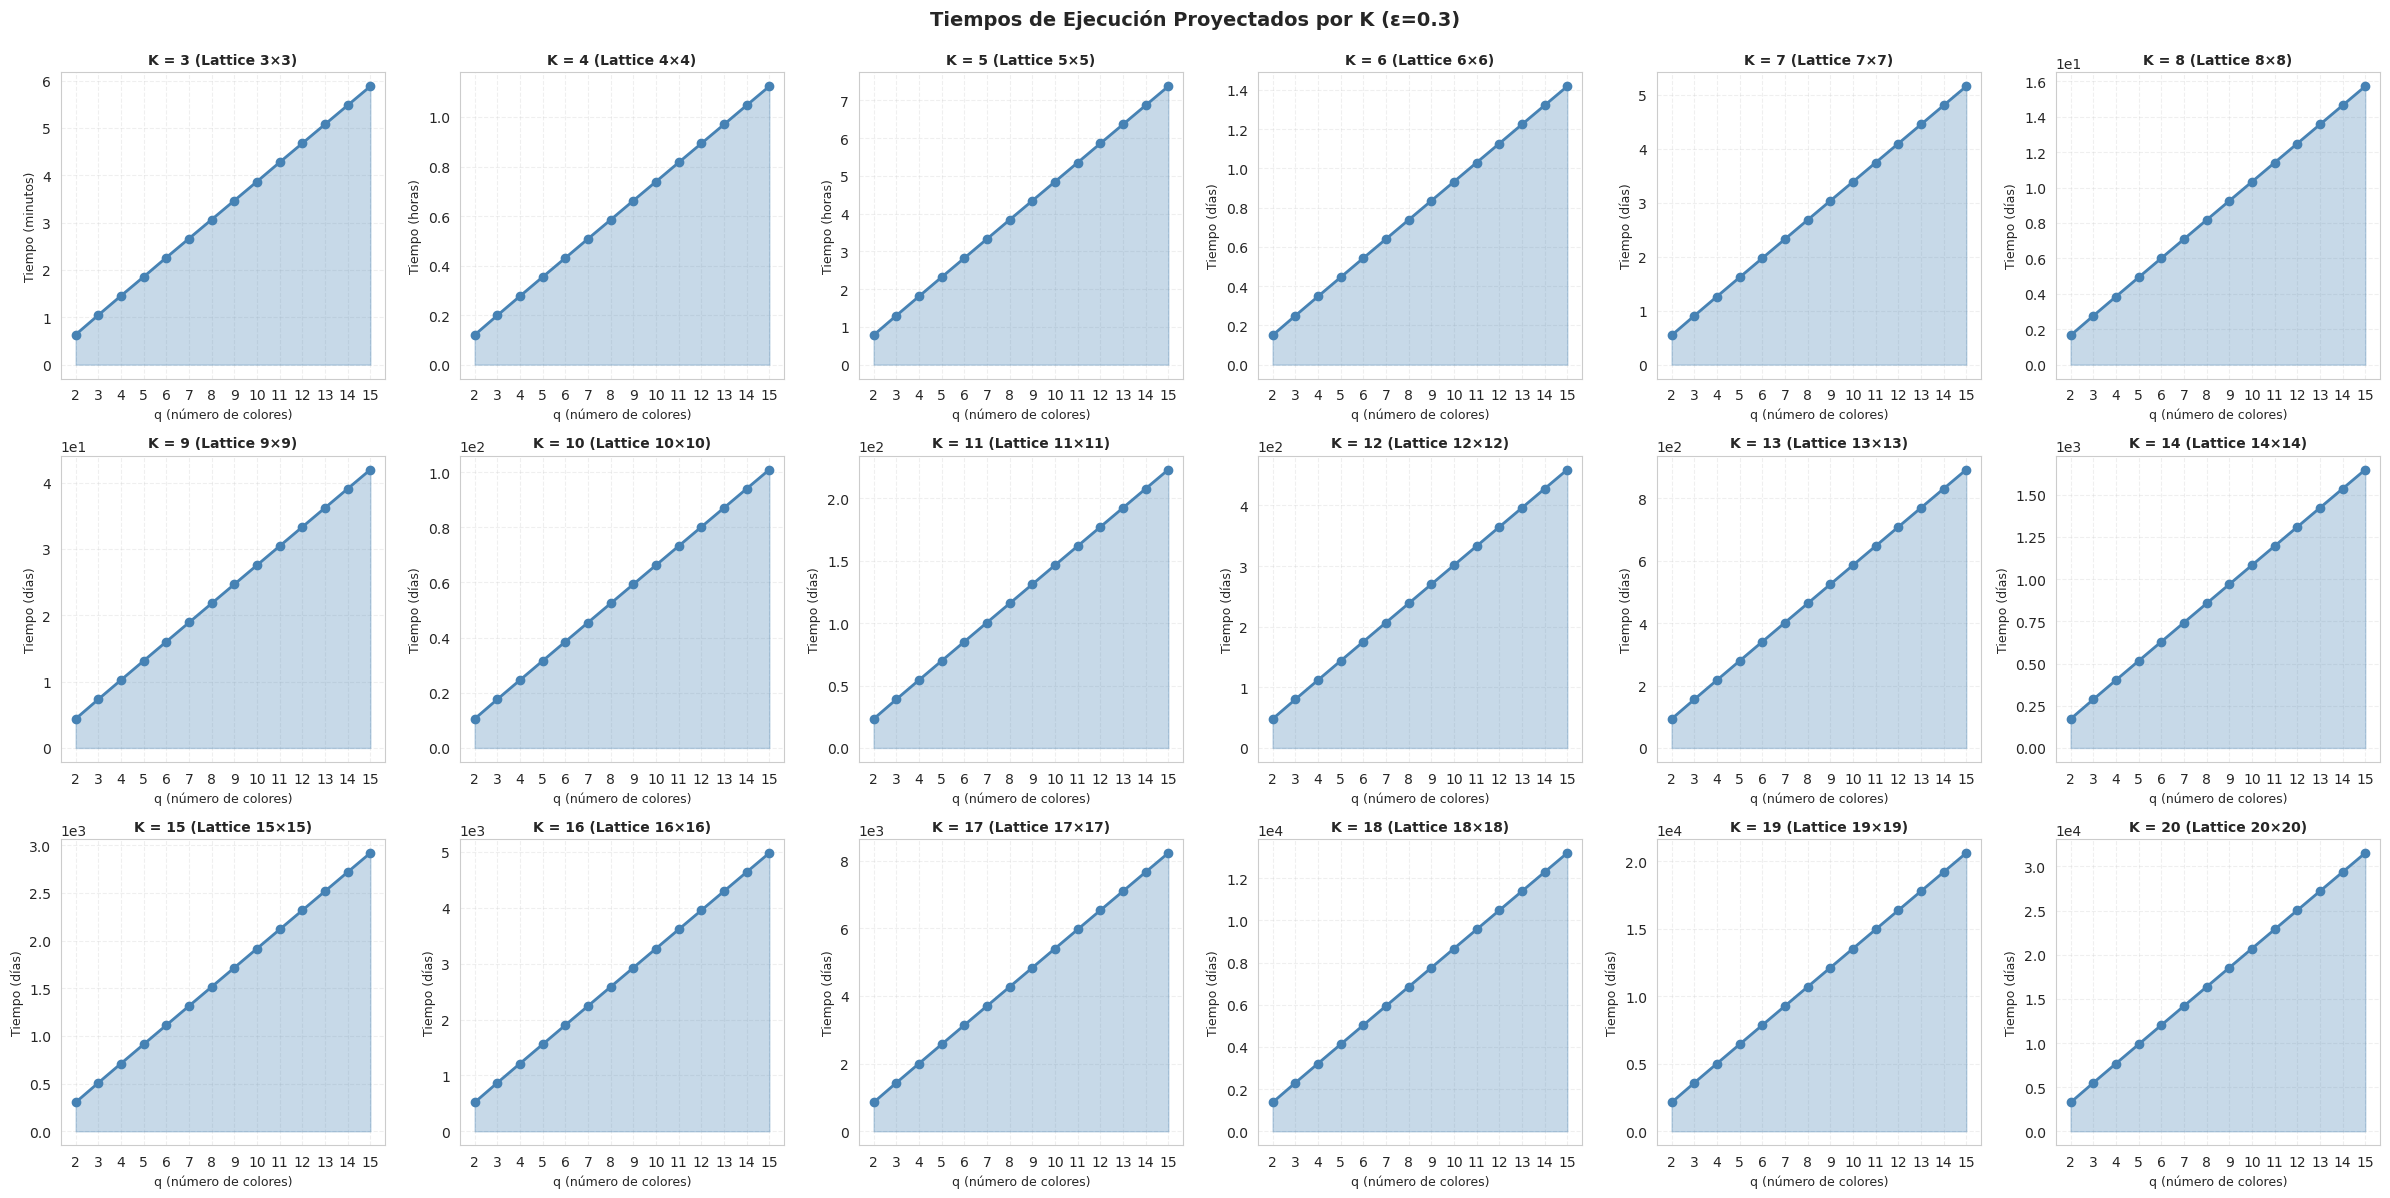


✅ Gráficas generadas y guardadas
   Archivo: results_telescopic/feasibility_plots.png


In [93]:
# Crear 18 gráficas individuales (una por cada K)
print("\n" + "="*80)
print("GENERANDO GRÁFICAS DE FACTIBILIDAD")
print("="*80)

# Crear figura con 18 subplots (grid 3x6)
fig, axes = plt.subplots(3, 6, figsize=(24, 12))
axes = axes.flatten()

# Función auxiliar para formatear tiempos
def format_time(seconds):
    """Retorna tiempo en la unidad más apropiada"""
    if seconds < 60:
        return seconds, 'segundos'
    elif seconds < 3600:
        return seconds / 60, 'minutos'
    elif seconds < 86400:
        return seconds / 3600, 'horas'
    else:
        return seconds / 86400, 'días'

# Para cada K, crear una gráfica
for idx, K in enumerate(K_VALUES):
    ax = axes[idx]
    
    # Filtrar datos para este K
    df_K = df_projection[df_projection['K'] == K]
    
    # Determinar escala automática según magnitud
    max_time_seg = df_K['tiempo_seg'].max()
    time_values, time_unit = format_time(max_time_seg)
    
    # Convertir todos los tiempos a la unidad seleccionada
    if time_unit == 'segundos':
        y_values = df_K['tiempo_seg'].values
    elif time_unit == 'minutos':
        y_values = df_K['tiempo_min'].values
    elif time_unit == 'horas':
        y_values = df_K['tiempo_horas'].values
    else:  # días
        y_values = df_K['tiempo_seg'].values / 86400
    
    # Graficar
    ax.plot(df_K['q'].values, y_values, marker='o', linewidth=2, markersize=6, color='steelblue')
    ax.fill_between(df_K['q'].values, y_values, alpha=0.3, color='steelblue')
    
    # Etiquetas y título
    ax.set_xlabel('q (número de colores)', fontsize=9)
    ax.set_ylabel(f'Tiempo ({time_unit})', fontsize=9)
    ax.set_title(f'K = {K} (Lattice {K}×{K})', fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xticks(Q_VALUES)
    
    # Formato de los valores del eje Y
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.suptitle('Tiempos de Ejecución Proyectados por K (ε=0.3)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()

# Guardar figura
plots_path = os.path.join(RESULTS_DIR, 'feasibility_plots.png')
plt.savefig(plots_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Gráficas generadas y guardadas")
print(f"   Archivo: {plots_path}")
print("="*80)

### **Fin del Análisis de Factibilidad**

Con base en las proyecciones anteriores, procedemos a ejecutar los experimentos principales.

---
## **11. EJECUCIÓN DE EXPERIMENTOS**

In [94]:
# DESCOMENTAR PARA EJECUTAR EXPERIMENTOS COMPLETOS
print("\n" + "="*80)
print("EXPERIMENTOS COMPLETOS: K=3..20")
print("="*80)

all_results = run_all_experiments(
    K_values=K_VALUES,
    epsilon=EPSILON,
    max_sims=MAX_SIMULATIONS,
    max_steps=MAX_GIBBS_STEPS,
    exact_timeout=EXACT_TIMEOUT_SECONDS,
    exact_timeout_q2=EXACT_TIMEOUT_SECONDS_Q2,
    q_values=Q_VALUES,
    results_dir=RESULTS_DIR
)

# Crear tabla resumen
df_summary = create_summary_table(all_results)
summary_path = os.path.join(RESULTS_DIR, 'summary_all_results.csv')
df_summary.to_csv(summary_path, index=False)
print(f"\n💾 Tabla resumen guardada: {summary_path}")

# Generar visualizaciones
plot_path = os.path.join(RESULTS_DIR, 'results_summary_telescopic.png')
plot_results_summary(all_results, save_path=plot_path)

print("\n" + "="*80)
print("EXPERIMENTOS COMPLETADOS CON ÉXITO")
print("="*80)
print(f"Resultados guardados en: {RESULTS_DIR}")
print("="*80)


EXPERIMENTOS COMPLETOS: K=3..20

################################################################################
# EXPERIMENTOS TELESCÓPICOS COMPLETOS
#
# K values:        [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
# q values:        [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
# epsilon:         0.5
# Max sims:        1000
# Max steps:       2000
# Exact timeout q=2: 600s (10.0 min) ⭐
# Exact timeout q>2: 180s (3.0 min)
#
# REGLA: Si q=2 hace timeout para un K, NO se calcularán exactos
#        para K mayores (complejidad solo crece)
#
# OPTIMIZACIONES: Disco para coloraciones + liberación explícita RAM
#
# Total K's:       18
################################################################################


EXPERIMENTO COMPLETO: K = 3

[FASE 1/2] Generando muestras MCMC y calculando exacto...
            (Guardando coloraciones a disco para optimizar RAM)


K=3, q's:   0%|          | 0/14 [00:00<?, ?it/s]

KeyboardInterrupt: 

---
## **12. ANÁLISIS DE RESULTADOS**

### **Cargar resultados existentes**

In [ ]:
# Cargar todos los CSVs generados
import glob

csv_files = glob.glob(os.path.join(RESULTS_DIR, 'results_K*.csv'))
print(f"\n📁 Archivos encontrados: {len(csv_files)}")

if len(csv_files) > 0:
    loaded_results = {}
    for csv_file in sorted(csv_files):
        K = int(csv_file.split('_K')[1].split('.csv')[0])
        loaded_results[K] = pd.read_csv(csv_file)
        print(f"   Cargado: K={K} ({loaded_results[K].shape[0]} filas)")
    
    df_all = create_summary_table(loaded_results)
    print(f"\n📊 DataFrame consolidado: {df_all.shape}")
    display(df_all.head(20))
else:
    print("⚠️  No se encontraron resultados. Ejecuta primero los experimentos.")


📁 Archivos encontrados: 18
   Cargado: K=10 (14 filas)
   Cargado: K=11 (14 filas)
   Cargado: K=12 (14 filas)
   Cargado: K=13 (14 filas)
   Cargado: K=14 (14 filas)
   Cargado: K=15 (14 filas)
   Cargado: K=16 (14 filas)
   Cargado: K=17 (14 filas)
   Cargado: K=18 (14 filas)
   Cargado: K=19 (14 filas)
   Cargado: K=20 (14 filas)
   Cargado: K=3 (14 filas)
   Cargado: K=4 (14 filas)
   Cargado: K=5 (14 filas)
   Cargado: K=6 (14 filas)
   Cargado: K=7 (14 filas)
   Cargado: K=8 (14 filas)
   Cargado: K=9 (14 filas)

📊 DataFrame consolidado: (252, 9)


,K,q,n_sims_actual,n_steps_actual,is_truncated,Z_estimate,exact_count,exact_status,error_rel_pct
0,10,2,1000,1829,True,1.000000e+00,NaN,SKIPPED,NaN
1,10,3,1000,2000,True,4.748840e+08,NaN,SKIPPED,NaN
2,10,4,1000,2000,True,4.839342e+19,NaN,SKIPPED,NaN
3,10,5,1000,2000,True,2.197600e+30,NaN,SKIPPED,NaN
4,10,6,1000,2000,True,1.265520e+39,NaN,SKIPPED,NaN
5,10,7,1000,2000,True,1.798322e+46,NaN,SKIPPED,NaN
6,10,8,1000,2000,True,2.085522e+52,NaN,SKIPPED,NaN
7,10,9,1000,2000,True,3.884075e+57,NaN,SKIPPED,NaN
8,10,10,1000,2000,True,1.988418e+62,NaN,SKIPPED,NaN
9,10,11,1000,2000,True,3.254222e+66,NaN,SKIPPED,NaN


### **Estadísticas descriptivas**

In [ ]:
if len(csv_files) > 0:
    print("\n" + "="*80)
    print("ESTADÍSTICAS DESCRIPTIVAS")
    print("="*80)
    
    # Conteos por status
    print("\n1. Status de conteo exacto:")
    status_counts = df_all['exact_status'].value_counts()
    print(status_counts)
    print(f"\n   Desglose:")
    for status in ['SUCCESS', 'TIMEOUT', 'SKIPPED', 'ERROR']:
        count = status_counts.get(status, 0)
        pct = (count / len(df_all) * 100) if len(df_all) > 0 else 0
        print(f"   {status:8s}: {count:3d} ({pct:5.1f}%)")
    
    # Errores relativos (donde hay exacto)
    df_with_exact = df_all[df_all['exact_status'] == 'SUCCESS'].copy()
    if len(df_with_exact) > 0:
        print("\n2. Errores relativos (%) [Solo casos con exacto]:")
        print(f"   Media:    {df_with_exact['error_rel_pct'].mean():.2f}%")
        print(f"   Mediana:  {df_with_exact['error_rel_pct'].median():.2f}%")
        print(f"   Std:      {df_with_exact['error_rel_pct'].std():.2f}%")
        print(f"   Min:      {df_with_exact['error_rel_pct'].min():.2f}%")
        print(f"   Max:      {df_with_exact['error_rel_pct'].max():.2f}%")
    
    # Truncamiento
    print("\n3. Casos truncados (límites aplicados):")
    n_truncated = df_all['is_truncated'].sum()
    print(f"   Truncados: {n_truncated}/{len(df_all)} ({n_truncated/len(df_all)*100:.1f}%)")
    
    # Efecto de q > 2d
    df_all['satisfies_theorem'] = df_all['q'] > 8  # 2d = 8
    print("\n4. Comparación q ≤ 8 vs q > 8 (restricción Theorem 9.1):")
    for satisfies, group in df_all[df_all['exact_status']=='SUCCESS'].groupby('satisfies_theorem'):
        label = "q > 8" if satisfies else "q ≤ 8"
        print(f"   {label}: Error medio = {group['error_rel_pct'].mean():.2f}%")


ESTADÍSTICAS DESCRIPTIVAS

1. Status de conteo exacto:
exact_status
SKIPPED    237
SUCCESS     11
TIMEOUT      4
Name: count, dtype: int64

   Desglose:
   SUCCESS :  11 (  4.4%)
   TIMEOUT :   4 (  1.6%)
   SKIPPED : 237 ( 94.0%)
   ERROR   :   0 (  0.0%)

2. Errores relativos (%) [Solo casos con exacto]:
   Media:    85.55%
   Mediana:  99.06%
   Std:      22.85%
   Min:      50.00%
   Max:      99.64%

3. Casos truncados (límites aplicados):
   Truncados: 252/252 (100.0%)

4. Comparación q ≤ 8 vs q > 8 (restricción Theorem 9.1):
   q ≤ 8: Error medio = 84.14%
   q > 8: Error medio = 99.64%


### **Visualizaciones adicionales**

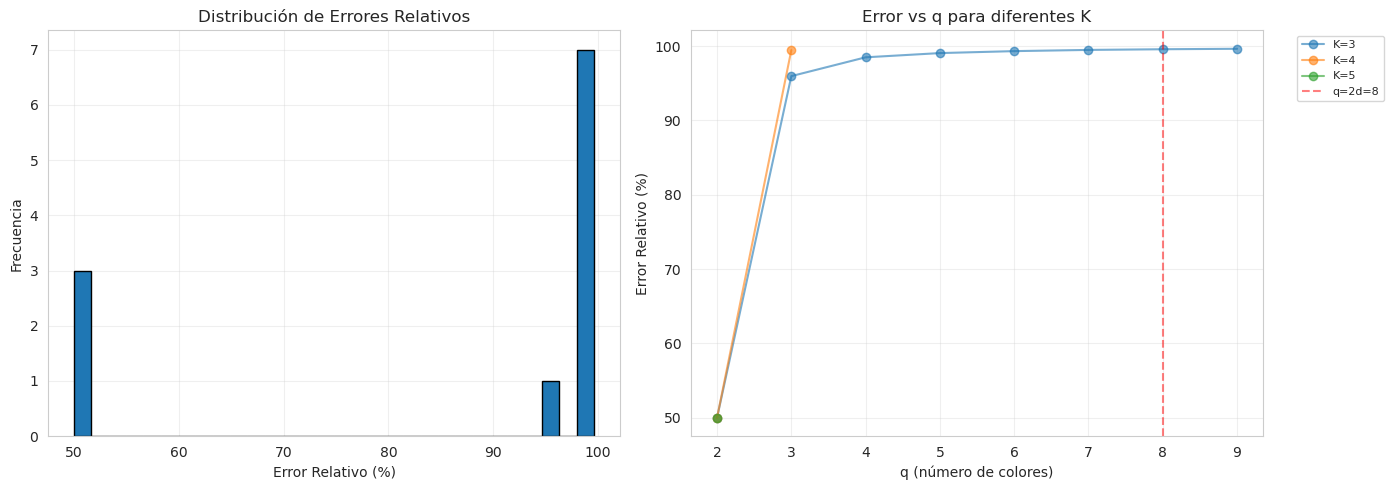

In [ ]:
if len(csv_files) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Distribución de errores
    ax1 = axes[0]
    if len(df_with_exact) > 0:
        df_with_exact['error_rel_pct'].hist(bins=30, ax=ax1, edgecolor='black')
        ax1.set_xlabel('Error Relativo (%)')
        ax1.set_ylabel('Frecuencia')
        ax1.set_title('Distribución de Errores Relativos')
        ax1.grid(True, alpha=0.3)
    
    # 2. Error vs q
    ax2 = axes[1]
    if len(df_with_exact) > 0:
        for K in df_with_exact['K'].unique():
            df_K = df_with_exact[df_with_exact['K'] == K]
            ax2.plot(df_K['q'], df_K['error_rel_pct'], marker='o', alpha=0.6, label=f'K={K}')
        ax2.axvline(x=8, color='red', linestyle='--', alpha=0.5, label='q=2d=8')
        ax2.set_xlabel('q (número de colores)')
        ax2.set_ylabel('Error Relativo (%)')
        ax2.set_title('Error vs q para diferentes K')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()